In [ ]:
!pip install torch transformers datasets pandas numpy scikit-learn tqdm accelerate matplotlib


import torch
import pandas as pd
import numpy as np
import transformers
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [22]:
# model
model_name = "prajjwal1/bert-tiny" # the smallest

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-1

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/46375 [00:00<?, ? examples/s]

<ipython-input-23-424a4dcc3a77>:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.175400,1.107979,0.689218,0.706747,0.689218,0.683907


✅ Model training complete and saved.


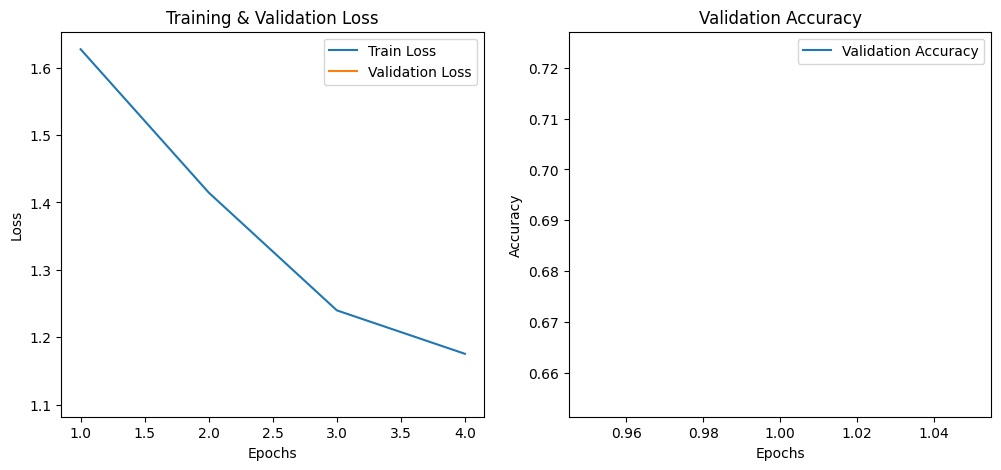

Evaluation Results: {'eval_loss': 1.1079792976379395, 'eval_accuracy': 0.6892183288409703, 'eval_precision': 0.7067467113793068, 'eval_recall': 0.6892183288409703, 'eval_f1': 0.683906655645976, 'eval_runtime': 11.7652, 'eval_samples_per_second': 315.338, 'eval_steps_per_second': 19.719, 'epoch': 1.0}


In [23]:
def load_and_preprocess_data(dataset_path):
    df = pd.read_csv(dataset_path)
    df.dropna(inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    label_mapping = {
        "anger": 0,
        "happiness": 1,
        "fear": 2,
        "sadness": 3,
        "surprise": 4,
        "disgust": 5,
        "neutral": 6
    }

    df["labels"] = df["main_category"].map(label_mapping).astype("int64")

    # Reduce Sequence Length
    def tokenize_function(examples):
        tokens = tokenizer(examples["text"], padding=True, truncation=True, max_length=128)
        tokens["labels"] = examples["labels"]
        return tokens

    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(tokenize_function, batched=True)
    dataset = dataset.train_test_split(test_size=0.2)
    dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.1).values()
    return dataset

# Training Settings
training_args = TrainingArguments(
    output_dir="moe_emotion_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # 🚀 Reduced epochs
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Accuracy, F1, Precision, and Recall
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


def train_model(dataset):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    train_result = trainer.train()
    trainer.save_model("moe_emotion_model")
    print("✅ Model training complete and saved.")

    # logs for plotting
    history = trainer.state.log_history
    epochs = list(range(1, len(history) + 1))

    train_loss = [log['loss'] for log in history if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
    eval_acc = [log.get('eval_accuracy', None) for log in history if 'eval_loss' in log]
    eval_acc = [x for x in eval_acc if x is not None]  # Remove None values


    # plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs[:len(train_loss)], train_loss, label="Train Loss")
    plt.plot(epochs[:len(eval_loss)], eval_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs[:len(eval_acc)], eval_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.show()

    # Evaluate the model on the validation set
    eval_results = trainer.evaluate(eval_dataset=dataset["validation"])
    print("Evaluation Results:", eval_results)

def evaluate_model(dataset):
    """
    Evaluate the model and display misclassified samples.
    """
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    results = trainer.evaluate(eval_dataset=dataset["validation"])
    print("📊 Evaluation Results:", results)

    # Predict on validation set
    predictions = trainer.predict(dataset["validation"])
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    # Identify misclassified examples
    df_val = dataset["validation"].to_pandas()
    df_val["predicted_label"] = preds
    df_val["correct"] = df_val["labels"] == df_val["predicted_label"]

    misclassified = df_val[df_val["correct"] == False]
    print("\n❌ Misclassified Samples:")
    print(misclassified[["text", "labels", "predicted_label"]].head(10))

    return results, misclassified


# Load and train
dataset = load_and_preprocess_data("/content/cropped_df.csv")
train_model(dataset)


In [24]:
# next step clean the code
# improve plots
# augment epocs
# use a more complex model